# Interpreting Machine Learning Models: Tools and Techniques

## Agenda

1. Why care about interpretability?
2. Inherently Interpretable Models
    - Linear Models
    - Decision Trees
3. Model-Agnostic Methods
    - ICE and PDP
    - LIME
    - SHAP

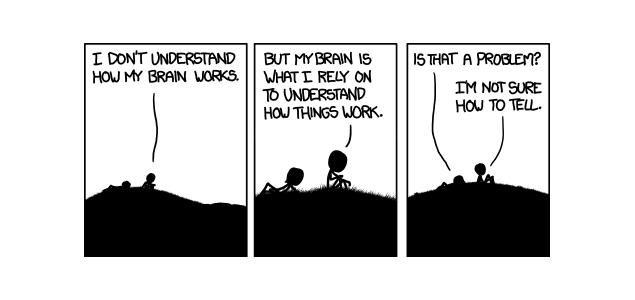

In [1]:
from IPython.display import Image
from IPython.display import display 
display(Image(filename='comic.png'))

## Why care about interpretability?

1. Problem Insight
2. Model Understanding
3. Accountability

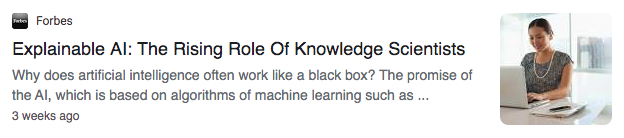

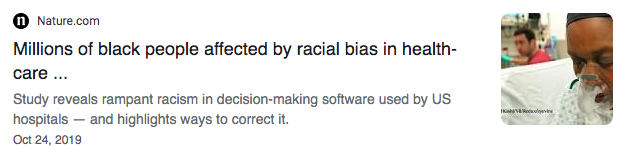

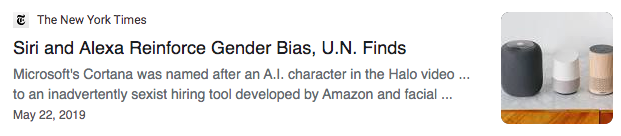

In [2]:
x = Image(filename='explai.png') 
y = Image(filename='aibias1.png')
z = Image(filename='aibias3.png') 
display(x, y, z)

- this isnt an issue only relevant to data scientists
- now that ml and ai applications are being widley deployed, people want to know how these models work
- customers and stakeholders have the right to know why a certain decision is made
- If you have a model that predicts credit worthiness
- even an unsuccessful model can provide problem insight
- as a data scientist you want to understand mechanics of model, why not just what, model robustness, driving factors
- difference between importance to your model and actually importance
 - ideally your model understannding should align with your business understanding
- If you know what features are important in your model, you can better understand how it will respond to unseen instances.
 - Identify hidden relationships
 - Identify spurious connections of a bad model
- importance to model does not imply actual importance --> shouldn't draw any causal conclusions
- if you cant explain why to your customers, why should they trust you
- most models rely on historical data --> propragate historical prejudice
- model bias

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', 1000)

# load titanic dataset. drop unused columns and na values
titanic_df = sns.load_dataset('titanic')
titanic_df.drop(['sibsp', 'parch', 'class', 'who', 'adult_male', 'deck',
                'embarked', 'alive', 'alone','embark_town'], 
                axis=1, 
                inplace=True)
titanic_df['sex'] = titanic_df['sex'].map({'male':0, 'female':1})
titanic_df.dropna(inplace=True)

# split features and target
X = titanic_df.drop('survived', axis=1) 
y = titanic_df['survived']
 
titanic_df.head(10)

,survived,pclass,sex,age,fare
0,0,3,0,22.0,7.2500
1,1,1,1,38.0,71.2833
2,1,3,1,26.0,7.9250
3,1,1,1,35.0,53.1000
4,0,3,0,35.0,8.0500
6,0,1,0,54.0,51.8625
7,0,3,0,2.0,21.0750
8,1,3,1,27.0,11.1333
9,1,2,1,14.0,30.0708
10,1,3,1,4.0,16.7000


## Interpretable Models

### Linear Models

For simple linear models (ex. linear and logistic regression) the relative feature importance can be estimated by the sign and magnitude of the coefficients

#### Pros
- Simple 
- Fast

#### Cons
- Simple
- Hides nonlinear relations
- Issues with collinearity

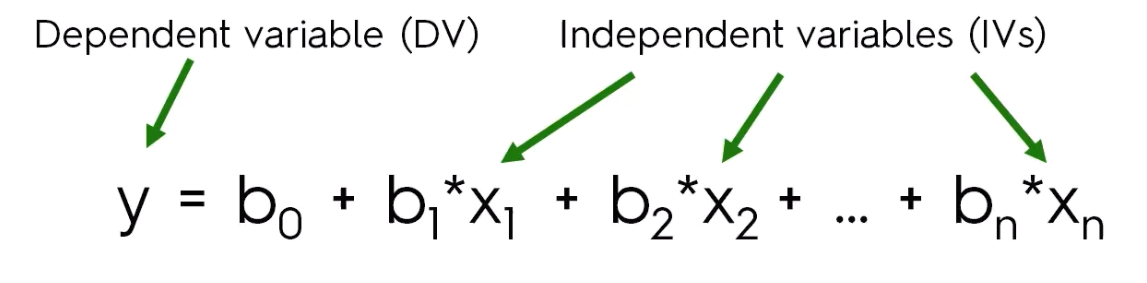

In [3]:
display(Image(filename='lreg.png'))

In [15]:
from sklearn.linear_model import LogisticRegression

# fit logistic regression model
lr = LogisticRegression(solver='lbfgs')
lr_model = lr.fit(X, y)

# get LS coefficients
coefficients = pd.concat([pd.DataFrame(X.columns),
                          pd.DataFrame(np.transpose(lr_model.coef_))],
                         axis = 1)
coefficients.columns = ['feature', 'coefficient']
 
coefficients.sort_values('coefficient', 
                         ascending=False)


,feature,coefficient
1,sex,2.406848
3,fare,0.000817
2,age,-0.035798
0,pclass,-1.220858


Pros
- You dont always need a complex model
- if the performance difference is am choose the simpler model

Cons
- a linear model may not be able to capture the complexities of the problem you are trying to solve
- age doesnt matter the same for all instances
- the more variables you have, the harder to interpret.
- the most important variables tend to dominate
- especially true concerning multicolinear features --> leads to unstable models ex. female vs not_male


### Decision Trees

Splits data into partitions which minimize the impurity of each partition

#### Pros
- Direct insight into rules
- Help identify simple areas of solution space

#### Cons
- Identifying nonlinear relations
- Interpreting tree ensembles (Random Forests, Boosted Trees)

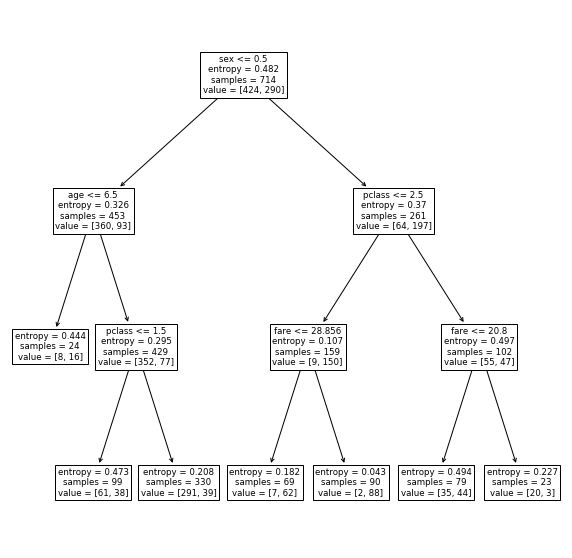

In [7]:
from sklearn.tree import DecisionTreeClassifier
from tools import get_rules
from sklearn import tree
 
dt = DecisionTreeClassifier(max_depth=3, 
                            min_samples_leaf=20)
dt_model = dt.fit(X, y)

fig, ax = plt.subplots(figsize=(10, 10))  # whatever size you want
tree.plot_tree(dt_model,
              feature_names = X.columns.to_list());
plt.show()

In [16]:
from sklearn.tree import DecisionTreeClassifier
from tools import get_rules
from sklearn import tree
 
dt = DecisionTreeClassifier(max_depth=3, 
                            min_samples_leaf=20)
dt_model = dt.fit(X, y)

get_rules(dt_model, X, titanic_df)

,leaf,total,purity,majority_class,rules
0,9,90,0.977778,1,"[sex > 0.5, pclass <= 2.5, fare > 28.856249809265137]"
1,8,69,0.898551,1,"[sex > 0.5, pclass <= 2.5, fare <= 28.856249809265137]"
2,5,330,0.881818,0,"[sex <= 0.5, age > 6.5, pclass > 1.5]"
3,12,23,0.869565,0,"[sex > 0.5, pclass > 2.5, fare > 20.800000190734863]"
4,2,24,0.666667,1,"[sex <= 0.5, age <= 6.5]"
5,4,99,0.616162,0,"[sex <= 0.5, age > 6.5, pclass <= 1.5]"
6,11,79,0.556962,1,"[sex > 0.5, pclass > 2.5, fare <= 20.800000190734863]"


- structure of the tree reflects the structure of the model
- the order in which the splits are made structures the solution space
- visual makes it easy to identify the nature of the solution space

## Model Agnostic Methods

- if we are dealling with complex models we need more sophisticated techniques
- however these models are harder to directly interpret

In [17]:
import xgboost

xg = xgboost.XGBClassifier(max_depth=3,
    num_estimators=100, 
    eta=.15)
xg_model = xg.fit(X, np.array(y))



### ICE and PDP

ICE (Individual Conditional Expectation)
- Vary one feature value while holding all other features constant 
 - Observe changes in prediction
- One line per instance

PDP (Partial Dependence Plot)
- Average of ICE plots



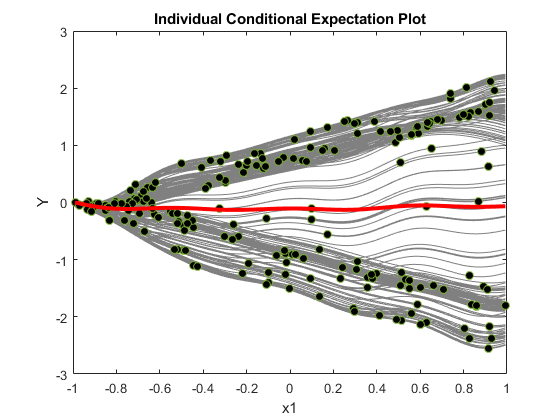

In [8]:
display(Image(filename='ice.png'))

Pros
- Only need access to model and instances your trying to predict
- Provides counterfacutal explanations

Cons
- PDP hides individual variation
- Unrealistic values for some instances
- Assumes feature independence

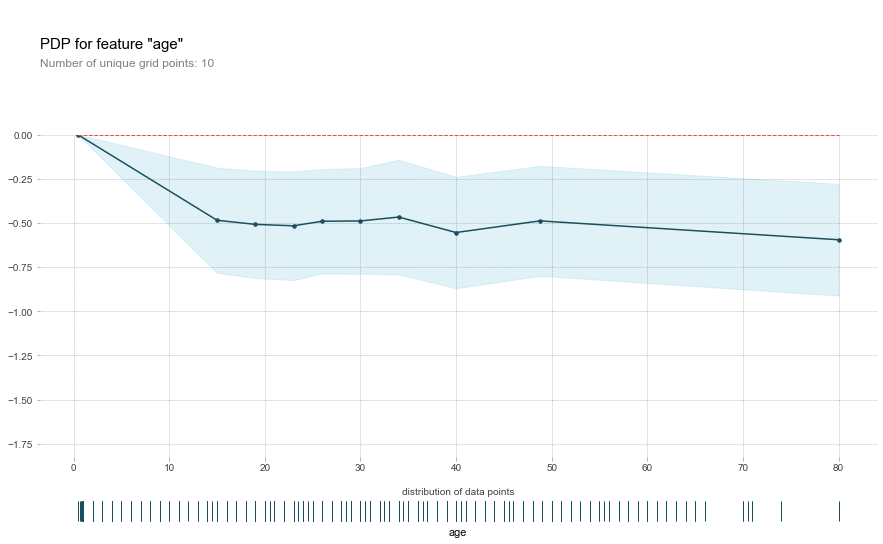

In [21]:
from pdpbox import pdp, get_dataset, info_plots

feature = 'age'

pdp_age = pdp.pdp_isolate(
    model=xg_model, 
    dataset=X, 
    model_features=X.columns.to_list(), 
    feature=feature
)  

# create pdp figure
fig, axes = pdp.pdp_plot(pdp_age, 
                         feature,
                         plot_pts_dist=True)


- at a global level the solution space may be very complex. but locally, it may be explainable by a linear model. thats the intuition behind the method
- perturbation analysis
- a feature can be postively correlated with the target for one instance but not another

### LIME (Local interpretable model-agnostic explanations)

Local linear approximation of the models behaviour

Pros
- Instance level explanations

Cons
- Unstable - similar points can have very different local explantions
- Defining neighborhood
- Linear assumptions

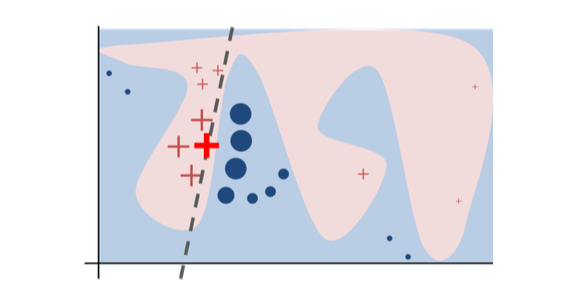

In [9]:
display(Image(filename='lime.png',
              unconfined=True))


In [24]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X.to_numpy(), 
                                                   feature_names=X.columns.to_list(), 
                                                   class_names=[0,1], 
                                                   discretize_continuous=True)

instance = 0   
exp = explainer.explain_instance(X.iloc[instance,:].to_numpy(),
                                 predict_fn=dt_model.predict_proba,
                                 num_features=4)
exp.show_in_notebook(show_all=False)

X.iloc[instance]

pclass     3.00
sex        0.00
age       22.00
fare       7.25
Name: 0, dtype: float64

- Generate data set of perturbed samples and fit a linear model explaining the predictions
- a little more complicated then simple regression in that a requlization scheme is used

### SHAP

1. Get all subsets of features S that do not contain X{i} 
2. Compute how predictions change when adding X{i} to those subsets
3. Aggregate contributions and compute the marginal contribution of the feature

Pros
- Strong theoretical foundation
- Provides global and local importance

Cons
- Slow


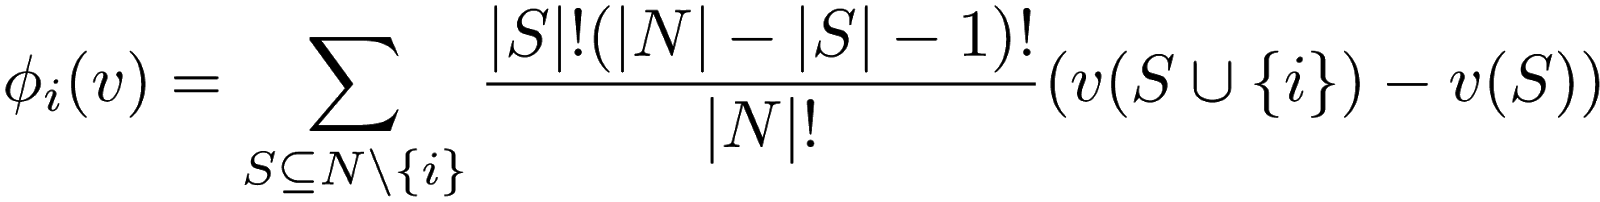

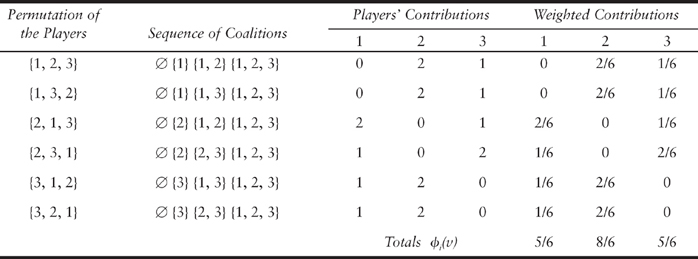

In [10]:
x = Image(filename='shp.png')
y = Image(filename='shap.png')
display(x, y)

In [28]:
import shap

# load JS visualization code to notebook
shap.initjs()
explainer = shap.TreeExplainer(xg_model)
shap_values = explainer.shap_values(X)

# shap.summary_plot(shap_values, 
#                   X, 
#                   plot_type="bar")
# shap.summary_plot(shap_values, 
#                   X)
# shap.dependence_plot("age", 
#                      shap_values, 
#                      X)
instance = 0 
shap.force_plot(explainer.expected_value, 
                shap_values[instance,:], 
                X.iloc[instance,:],
                feature_names=X.columns)

- based on a concept of game theory for determining the allocation of payout in a cooperative game

- value corresponds to the contribution of each feature towards pushing the prediction away from the expected value

- global: the shapley value of each feature acorss all instances

- computation time increases exponentially with the number of features

- most implementations are approximations based on monte carlo sampling

- requires access to data on model vs lime you only need the model and instance to perturb

- "The Shapley value for each variable (payout) is basically trying to find the correct weight such that the sum of all Shapley values is the difference between the predictions and average value of the model."

- "SHAP does not go on and retrain the model for each subset. Instead, for the removed or left out feature, it just replaces it with the average value of the feature and generates the predictions."


### Resources

Goldstein, Alex, et al. “Peeking Inside the Black Box: Visualizing Statistical Learning with Plots of Individual Conditional Expectation.” ArXiv:1309.6392 [Stat], Mar. 2014. arXiv.org, http://arxiv.org/abs/1309.6392

Kim, Been, et al. “Interpretability Beyond Feature Attribution: Quantitative Testing with Concept Activation Vectors (TCAV).” ArXiv:1711.11279 [Stat], June 2018. arXiv.org, http://arxiv.org/abs/1711.11279

Lundberg, Scott, and Su-In Lee. “A Unified Approach to Interpreting Model Predictions.” ArXiv:1705.07874 [Cs, Stat], Nov. 2017. arXiv.org, http://arxiv.org/abs/1705.07874

Lundberg, Scott M., et al. “Explainable AI for Trees: From Local Explanations to Global Understanding.” ArXiv:1905.04610 [Cs, Stat], May 2019. arXiv.org, http://arxiv.org/abs/1905.04610

Molnar, Christoph. "Interpretable machine learning. A Guide for Making Black Box Models Explainable", 2019. https://christophm.github.io/interpretable-ml-book/

Ribeiro, Marco Tulio, et al. “‘Why Should I Trust You?’: Explaining the Predictions of Any Classifier.” ArXiv:1602.04938 [Cs, Stat], Aug. 2016. arXiv.org, http://arxiv.org/abs/1602.04938

